In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE

In [2]:
# Importing the dataset.

pd.set_option('display.max_columns', None)

data = pd.read_csv('C:\\Users\\JAHFAITH IROKANULO\\Downloads\\shootings.csv')
data.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects


In [3]:
data.isna().values.sum()

0

In [4]:
data.shape

(4895, 15)

In [5]:
drop_col = ['id', 'name', 'date', 'manner_of_death', 'city', 'state']

df = data.drop(drop_col, axis=1)
df.shape

(4895, 9)

In [6]:
df['threat_level'].value_counts()

attack          3160
other           1528
undetermined     207
Name: threat_level, dtype: int64

In [7]:
df['flee'].value_counts()

Not fleeing    3073
Car             820
Foot            642
Other           360
Name: flee, dtype: int64

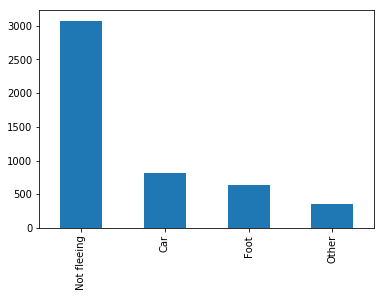

In [8]:
df['flee'].value_counts().plot(kind='bar')

## Defining the target column.

Treating data points where threat_level is either 'other' or 'undetermined' as 0(not attack minded) and otherwise (where the person attacked) as
1(as attack minded).

Summary: 0 represents a non attacking person while 1 represents an attacking individual.

In [9]:
def target_feat(df):
    if (df['threat_level'] == 'other' or df['threat_level'] == 'undetermined'):
        return 0
    else:
        return 1

In [10]:
# Creating the target column.

df['threat_level'] = df.apply(target_feat, axis=1)
df.shape

(4895, 9)

In [11]:
df['threat_level'].value_counts()

1    3160
0    1735
Name: threat_level, dtype: int64

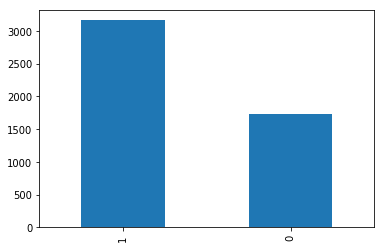

In [12]:
df['threat_level'].value_counts().plot(kind='bar')

## Treating Booleans.

In [13]:
bool_feat = df.select_dtypes(include=bool)
bool_feat.head()

,signs_of_mental_illness,body_camera
0,True,False
1,False,False
2,False,False
3,True,False
4,False,False


In [14]:
# Converting booleans to string -so that they can be dummified.

df['signs_of_mental_illness'] = df['signs_of_mental_illness'].astype('str')
df['body_camera'] = df['body_camera'].astype('str')

In [15]:
# Checking the output.

df['body_camera'].dtype, df['signs_of_mental_illness'].dtype

(dtype('O'), dtype('O'))

In [16]:
# Treating categorical features.

cat_feat = df.select_dtypes(include=object)
cat_feat.head()

,armed,gender,race,signs_of_mental_illness,flee,body_camera,arms_category
0,gun,M,Asian,True,Not fleeing,False,Guns
1,gun,M,White,False,Not fleeing,False,Guns
2,unarmed,M,Hispanic,False,Not fleeing,False,Unarmed
3,toy weapon,M,White,True,Not fleeing,False,Other unusual objects
4,nail gun,M,Hispanic,False,Not fleeing,False,Piercing objects


After observing the correlation matrix from a previous analysis, we'd drop 'armed' cos it correlates highly with 'arms_category', and when compared with 'arms_category' it correlates relatively lower with the target. 

In [17]:
cat_feat = cat_feat.drop('armed', axis=1)

# Also dropping 'armed' from df.
df = df.drop('armed', axis=1)

In [18]:
# Dummifying cat_features.

dummy_cat = pd.get_dummies(cat_feat, drop_first=True)
dummy_cat.head()

,gender_M,race_Black,race_Hispanic,race_Native,race_Other,race_White,signs_of_mental_illness_True,flee_Foot,flee_Not fleeing,flee_Other,body_camera_True,arms_category_Electrical devices,arms_category_Explosives,arms_category_Guns,arms_category_Hand tools,arms_category_Multiple,arms_category_Other unusual objects,arms_category_Piercing objects,arms_category_Sharp objects,arms_category_Unarmed,arms_category_Unknown,arms_category_Vehicles
0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [19]:
# Adding the dummified categorical features to the main dataset.

df = pd.concat([dummy_cat, df], axis=1)
df.shape

(4895, 30)

In [20]:
df.head()

,gender_M,race_Black,race_Hispanic,race_Native,race_Other,race_White,signs_of_mental_illness_True,flee_Foot,flee_Not fleeing,flee_Other,body_camera_True,arms_category_Electrical devices,arms_category_Explosives,arms_category_Guns,arms_category_Hand tools,arms_category_Multiple,arms_category_Other unusual objects,arms_category_Piercing objects,arms_category_Sharp objects,arms_category_Unarmed,arms_category_Unknown,arms_category_Vehicles,age,gender,race,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,53.0,M,Asian,True,1,Not fleeing,False,Guns
1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,47.0,M,White,False,1,Not fleeing,False,Guns
2,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,23.0,M,Hispanic,False,0,Not fleeing,False,Unarmed
3,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,32.0,M,White,True,1,Not fleeing,False,Other unusual objects
4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,39.0,M,Hispanic,False,1,Not fleeing,False,Piercing objects


In [21]:
# Drop the original categorical features since we have the dummies.

drop_col = ['body_camera', 'signs_of_mental_illness', 'gender', 'race', 'arms_category', 'flee']

df = df.drop(drop_col, axis=1)

df.shape

(4895, 24)

In [22]:
df.head()

,gender_M,race_Black,race_Hispanic,race_Native,race_Other,race_White,signs_of_mental_illness_True,flee_Foot,flee_Not fleeing,flee_Other,body_camera_True,arms_category_Electrical devices,arms_category_Explosives,arms_category_Guns,arms_category_Hand tools,arms_category_Multiple,arms_category_Other unusual objects,arms_category_Piercing objects,arms_category_Sharp objects,arms_category_Unarmed,arms_category_Unknown,arms_category_Vehicles,age,threat_level
0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,53.0,1
1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,47.0,1
2,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,23.0,0
3,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,32.0,1
4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,39.0,1


## Correlation.

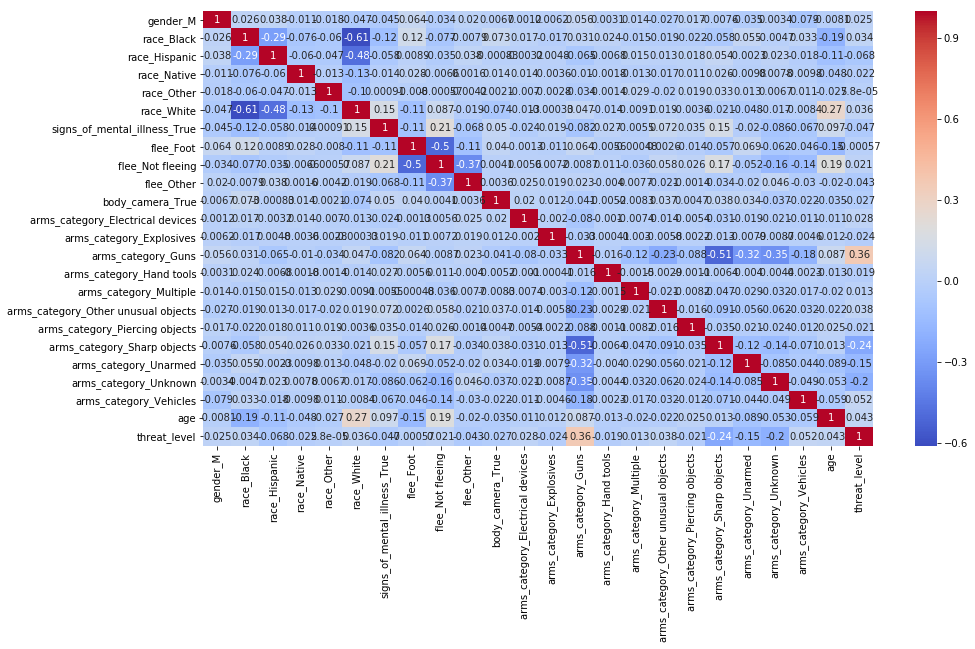

In [23]:
plt.figure(figsize=(15,8))

corr_mat = df.corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')

In [24]:
corr_mat['threat_level'].sort_values(ascending=False)

threat_level                           1.000000
arms_category_Guns                     0.364092
arms_category_Vehicles                 0.051952
age                                    0.042978
arms_category_Other unusual objects    0.037517
race_White                             0.035537
race_Black                             0.033928
arms_category_Electrical devices       0.027555
gender_M                               0.025274
flee_Not fleeing                       0.020501
arms_category_Multiple                 0.012839
race_Other                             0.000058
flee_Foot                             -0.000566
arms_category_Hand tools              -0.019291
arms_category_Piercing objects        -0.020709
race_Native                           -0.021669
arms_category_Explosives              -0.023648
body_camera_True                      -0.026643
flee_Other                            -0.043195
signs_of_mental_illness_True          -0.047071
race_Hispanic                         -0

In [25]:
# Splitting into dependent and independent variables.

X = df.drop(['threat_level'], axis=1)
y = df['threat_level']

X.shape, y.shape

((4895, 23), (4895,))

In [26]:
# Importing more libraries.

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

## Modeling.

In [27]:
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [28]:
for tr, te in fold.split(X, y):
    
    #Splitting into train and test sets.
    X_train, X_test = X.iloc[tr], X.iloc[te]
    y_train, y_test = y.iloc[tr], y.iloc[te]
    
    #Applying SMOTE
    #sm = SMOTE(random_state=12)
    #X_train, y_train = sm.fit_sample(X_train, y_train)
    
    #Training
    model1 = LogisticRegression()
    model1.fit(X_train, y_train)
    
    #Prediction
    train_pred = model1.predict(X_train)
    test_pred = model1.predict(X_test)
    
    #Evaluation
    roc_train = f1_score(y_train, train_pred)
    roc_test = f1_score(y_test, test_pred) 
     
    print('Train Eval:', roc_train)
    print('Test Eval:', roc_test)
    print('')
    
con_mat = confusion_matrix(test_pred, y_test)
auc = roc_auc_score(test_pred, y_test)
    
print('Confusion matrix:\n', con_mat)
print('AUC:', auc)

C:\Users\JAHFAITH IROKANULO\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\JAHFAITH IROKANULO\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

Train Eval: 0.7965402005111067
Test Eval: 0.7822014051522248

Train Eval: 0.7959540945341373
Test Eval: 0.7925407925407925

Train Eval: 0.7963288420230423
Test Eval: 0.7947732513451192

Train Eval: 0.7933980582524273
Test Eval: 0.7984555984555984

Train Eval: 0.7948916408668731
Test Eval: 0.8019169329073482

Confusion matrix:
 [[229 130]
 [118 502]]
AUC: 0.7237802138556924


C:\Users\JAHFAITH IROKANULO\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [29]:
val_score = cross_val_score(model1, X, y, cv=5)
val_score

C:\Users\JAHFAITH IROKANULO\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\JAHFAITH IROKANULO\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

array([0.79366701, 0.74463739, 0.70480082, 0.68845761, 0.70684372])

In [30]:
print(val_score.mean())

0.7276813074565884


In [38]:
for tr, te in fold.split(X, y):
    
    #Splitting into train and test sets.
    X_train, X_test = X.iloc[tr], X.iloc[te]
    y_train, y_test = y.iloc[tr], y.iloc[te]
    
    #Applying SMOTE
    #sm = SMOTE(random_state=12)
    #X_train, y_train = sm.fit_sample(X_train, y_train)
    
    #Training
    model2 = RandomForestClassifier(max_depth=4, max_features=7, min_samples_split=6, 
                                    n_estimators=300, random_state=12)
    model2.fit(X_train, y_train)
    
    #Prediction
    train_pred = model2.predict(X_train)
    test_pred = model2.predict(X_test)
    
    #Evaluation
    roc_train = f1_score(y_train, train_pred) 
    roc_test = f1_score(y_test, test_pred) 
    
    print('Train Eval:', roc_train)
    print('Test Eval:', roc_test)
    print('')
    
con_mat = confusion_matrix(test_pred, y_test)
auc = roc_auc_score(test_pred, y_test)
    
print('Confusion matrix:\n', con_mat)
print('AUC:', auc)

Train Eval: 0.7982998454404946
Test Eval: 0.7830115830115829

Train Eval: 0.795283201237193
Test Eval: 0.7950693374422189

Train Eval: 0.7958946553059644
Test Eval: 0.7960426179604262

Train Eval: 0.7934235976789168
Test Eval: 0.803379416282642

Train Eval: 0.7944679216288897
Test Eval: 0.7993680884676145

Confusion matrix:
 [[219 126]
 [128 506]]
AUC: 0.7164449321080785


In [39]:
val_score = cross_val_score(model2, X, y, cv=5)
val_score

array([0.78958121, 0.73850868, 0.70480082, 0.68743616, 0.72114402])

In [40]:
print(val_score.mean())

0.7282941777323799


In [37]:
#from sklearn.model_selection import GridSearchCV

In [38]:
#param = {'n_estimators': [100, 300, 500], 'max_depth': [None, 4, 7, 10], 'max_features':['auto', 7, 10, 15, 20], 
#        'min_samples_split': [2, 4, 6, 8, 10]}

In [39]:
#grid = GridSearchCV(model2, param_grid=param, cv=5)
#grid.fit(X_train, y_train)

In [40]:
#grid.best_params_

In [41]:
#grid.best_score_